In [1]:
# import all required packages
import pandas as pd
import numpy as np
from datetime import datetime

# package for MLP 
import tensorflow as tf

# Plot related packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# math package
import math

# dataset related packages
from tensorflow.examples.tutorials.mnist import input_data

/home/amd_3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


%%HTML
<ul>
<li> The data is already standardized to fall in the range 0.0 to 1.0 </li>
</ul>

# UTIL functions

In [3]:
def plot_loss_curve(train_metric_list, val_metric_list):
    """
    This function plots the loss curve for train and validation
    """
    
    # get x-label list
    epcoh_list = range(1, len(train_metric_list) + 1 )
    
    # get train_accuracy data
    train_acc_list = [ item[1] for item in train_metric_list]
    
    # get validation accuracy data
    val_acc_list = [ item[1] for item in val_metric_list]
    
    # plot both train, validation curve
    plt.plot(epcoh_list, train_acc_list, label='Train Loss', color='r')
    plt.plot(epcoh_list, val_acc_list, label='Validation Loss', color='b')
    plt.xlabel('Training Epoch')
    plt.ylabel('Cross Entropy Error')
    plt.title('Training Loss Vs Validation Loss')
    plt.legend()
    plt.show()

In [4]:
def plot_accuracy_curve(train_metric_list, val_metric_list):
    """
    This function plots the accuracy curve for train and validation
    """
    
    # get x-label list
    epcoh_list = range(1, len(train_metric_list) + 1 )
    
    # get train_accuracy data
    train_acc_list = [ item[2] for item in train_metric_list]
    
    # get validation accuracy data
    val_acc_list = [ item[2] for item in val_metric_list]
    
    # plot both train, validation curve
    plt.plot(epcoh_list, train_acc_list, label='Train Accuracy', color='r')
    plt.plot(epcoh_list, val_acc_list, label='Validation Accuracy', color='b')
    plt.xlabel('Training Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Vs Validation Accuracy')
    plt.legend()
    plt.show()

# MODEL

In [5]:
# declare placeholders for input and output
X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
keep_probability = tf.placeholder(tf.float32) # This is for dropout in a layer

In [6]:
def train_and_evaluate_model(custom_model, keep_prob_val, num_epochs = 2):
    """
    This function train and evaluate the model
    """

    batch_size = 100
    total_batchs = int(mnist.train.num_examples / batch_size)
    
    # define the loss function
    cee = tf.reduce_mean(-tf.reduce_sum(y * tf.log(custom_model), reduction_indices=[1]))
    # defien the train step
    train_step = tf.train.AdamOptimizer(1e-03).minimize(cee)
    # define the accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1), tf.argmax(custom_model,1)), tf.float32)) * 100.0
    

    # declare two list for holding loss, accuracy for both train, validation
    train_metric_list = list()
    val_metric_list = list()

    # create a session and execute the code
    with tf.Session() as sess:

        # initialize variables
        tf.global_variables_initializer().run()

        # run multiple epochs
        for epoch in range(1, num_epochs + 1):

            # run batch by batch
            for batch_id in range(total_batchs):

                # get the train data into features and labels
                X_train, y_train = mnist.train.next_batch(batch_size)

                # run the training
                _ = sess.run([train_step], feed_dict={X:X_train, y:y_train, keep_probability : keep_prob_val})


            # find predicted value, loss and accuracy for both train &test data sets
            tr_pred, tr_cee, tr_acc = sess.run([custom_model, cee, accuracy], feed_dict={X:mnist.train.images, 
                                                                               y:mnist.train.labels,
                                                                               keep_probability : 1.0})
            train_metric_list.append((tr_pred, tr_cee, tr_acc,))

            val_pred, val_cee, val_acc = sess.run([custom_model, cee, accuracy], feed_dict={X:mnist.validation.images,
                                                                                  y:mnist.validation.labels,
                                                                                  keep_probability : 1.0})
            val_metric_list.append((val_pred, val_cee, val_acc,))
            
        # Test the model
        ts_pred, ts_cee, ts_acc = sess.run([custom_model, cee, accuracy], feed_dict={X : mnist.test.images,
                                                                          y : mnist.test.labels,
                                                                          keep_probability : 1.0})
    
        test_loss = ts_cee.mean()
        
        print('Test accuracy of model :%f, Test loss:%f'%(ts_acc, test_loss,))            
            
    return (test_loss, ts_acc, train_metric_list, val_metric_list,)

## a) MLP with 2 hidden layer, relu

In [7]:
def build_model_a(X):
    """
    This functions builds the architecture for the MLP.
    """

    # model architecture
    num_input_neurons = 784
    num_hidden_neurons_1 =  512
    num_hidden_neurons_2 = 128
    num_output_neurons = 10
    
    # for relu activation function we need to use He normal initialization of weights as follows
    # If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
    # weights =>  σ=√(2/(fan_in+1) => N(0,σ)
    
    # relu activation specific standard deviations
    l1_stddev = math.sqrt(2 / (num_input_neurons + 1))
    l2_stddev = math.sqrt(2 / (num_hidden_neurons_1 + 1))
    out_stddev = math.sqrt(2 / (num_hidden_neurons_2 + 1))
    

    # ====================================== hidden layer 1 ============================================
    l1_weights = tf.Variable(tf.random_normal(shape=[num_input_neurons, num_hidden_neurons_1], 
                                              mean=0.0, stddev=l1_stddev))
    l1_biases  = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_1], mean=0.0, stddev=l1_stddev))
    
    l1_net_input = tf.matmul(X, l1_weights) + l1_biases
    l1_output = tf.nn.relu(l1_net_input) # activation function
    #===================================================================================================
    
     # ====================================== hidden layer 2 ============================================
    l2_weights = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_1, num_hidden_neurons_2], 
                                              mean=0.0, stddev=l2_stddev))
    l2_biases  = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_2], mean=0.0, stddev=l2_stddev))
    
    l2_net_input = tf.matmul(l1_output, l2_weights) + l2_biases
    l2_output = tf.nn.relu(l2_net_input) # activation function
    #===================================================================================================
    
    
    
    # ================================  output layer ===================================================
    l3_weights = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_2, num_output_neurons], 
                                              mean=0.0, stddev=out_stddev))
    l3_biases  = tf.Variable(tf.random_normal(shape=[num_output_neurons], mean=0.0, stddev=out_stddev))
    
    l3_net_input = tf.matmul(l2_output, l3_weights) + l3_biases
    
    # ==================================================================================================
    
    # return output using the softmax layer
    output = tf.nn.softmax(l3_net_input)
    
    return output

Test accuracy of model :98.000000, Test loss:0.074359


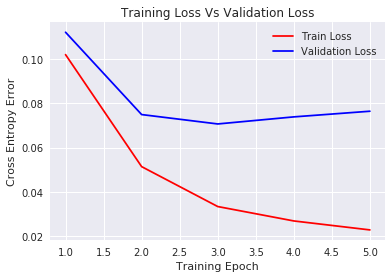

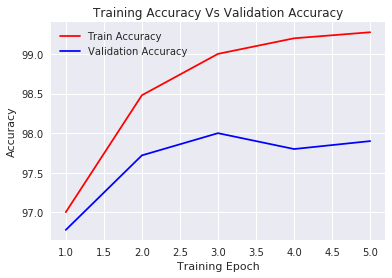

In [8]:
# buid the model a
mlp_a = build_model_a(X)

# train and evaluate the model
keep_prob_val = 1.0
num_epochs = 5

ts_loss_mlp_a, ts_acc_mlp_a, train_metric_list, val_metric_list = train_and_evaluate_model(mlp_a , keep_prob_val,
                                                                                           num_epochs)

# plot the loss curve
plot_loss_curve(train_metric_list, val_metric_list)
# plot the accuracy curve
plot_accuracy_curve(train_metric_list, val_metric_list)

### Observation

%%HTML
<ul>
<li> As the number of epochs pass 3, validation loss starts increasing slightly</li>
</ul>

## b) MLP with 3 Hidden layers, dropout, batch normalization

In [9]:
def build_model_b(X):
    """
    This functions builds the architecture for the MLP.
    """

    # model architecture
    num_input_neurons = 784
    num_hidden_neurons_1 =  432
    num_hidden_neurons_2 = 234
    num_hidden_neurons_3 = 110
    num_output_neurons = 10
    
    # for relu activation function we need to use He normal initialization of weights as follows
    # If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
    # weights =>  σ=√(2/(fan_in+1) => N(0,σ)
    
    # relu activation specific standard deviations
    l1_stddev = math.sqrt(2 / (num_input_neurons + 1))
    l2_stddev = math.sqrt(2 / (num_hidden_neurons_1 + 1))
    l3_stddev = math.sqrt(2 / (num_hidden_neurons_2 + 1))
    out_stddev = math.sqrt(2 / (num_hidden_neurons_3 + 1))
    

    # ====================================== hidden layer 1 ============================================
    l1_weights = tf.Variable(tf.random_normal(shape=[num_input_neurons, num_hidden_neurons_1], 
                                              mean=0.0, stddev=l1_stddev))
    l1_biases  = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_1], mean=0.0, stddev=l1_stddev))
    
    l1_net_input = tf.matmul(X, l1_weights) + l1_biases
    l1_output = tf.nn.relu(l1_net_input) # activation function
    #===================================================================================================
    
     # ====================================== hidden layer 2 ============================================
    l2_weights = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_1, num_hidden_neurons_2], 
                                              mean=0.0, stddev=l2_stddev))
    l2_biases  = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_2], mean=0.0, stddev=l2_stddev))
    
    l2_net_input = tf.matmul(l1_output, l2_weights) + l2_biases
    
    # apply batch normalization
    # Calculate the mean and variance of x.
    batch_mean_l2, batch_var_l2 = tf.nn.moments(l2_net_input, [0])
    
    alpha_l2 = tf.Variable(tf.ones([num_hidden_neurons_2]))
    beta_l2 = tf.Variable(tf.zeros([num_hidden_neurons_2]))
    
    # do batch normalization on net input
    epsilon = 1e-03
    l2_net_input = tf.nn.batch_normalization(l2_net_input, batch_mean_l2, batch_var_l2, 
                                               beta_l2, alpha_l2, epsilon)
    
    
    
    l2_output = tf.nn.relu(l2_net_input) # activation function
    l2_output = tf.nn.dropout(l2_output, keep_prob=keep_probability)
    #===================================================================================================
    
    # ====================================== hidden layer 3 ============================================
    l3_weights = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_2, num_hidden_neurons_3], 
                                              mean=0.0, stddev=l3_stddev))
    l3_biases  = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_3], mean=0.0, stddev=l3_stddev))
    
    l3_net_input = tf.matmul(l2_output, l3_weights) + l3_biases
    
    # apply batch normalization
    # Calculate the mean and variance of x.
    batch_mean_l3, batch_var_l3 = tf.nn.moments(l3_net_input, [0])
    
    alpha_l3 = tf.Variable(tf.ones([num_hidden_neurons_3]))
    beta_l3 = tf.Variable(tf.zeros([num_hidden_neurons_3]))
    
    # do batch normalization on net input
    epsilon = 1e-03
    l3_net_input = tf.nn.batch_normalization(l3_net_input, batch_mean_l3, batch_var_l3, 
                                               beta_l3, alpha_l3, epsilon)
    
    
    
    l3_output = tf.nn.relu(l3_net_input) # activation function
    l3_output = tf.nn.dropout(l3_output, keep_prob=keep_probability)
    #===================================================================================================
    
    
    
    # ================================  output layer ===================================================
    l4_weights = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_3, num_output_neurons], 
                                              mean=0.0, stddev=out_stddev))
    l4_biases  = tf.Variable(tf.random_normal(shape=[num_output_neurons], mean=0.0, stddev=out_stddev))
    
    l4_net_input = tf.matmul(l3_output, l4_weights) + l4_biases
    
    # ==================================================================================================
    
    # return output using the softmax layer
    output = tf.nn.softmax(l4_net_input)
    
    return output

With keep probability: 0.800000
Test accuracy of model :98.009995, Test loss:0.069162


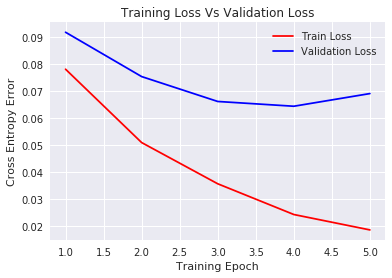

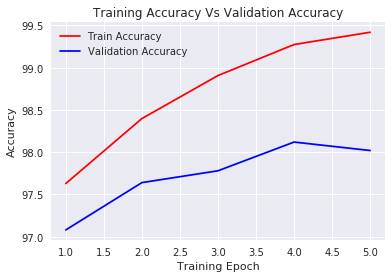

With keep probability: 0.840000
Test accuracy of model :98.199997, Test loss:0.061258


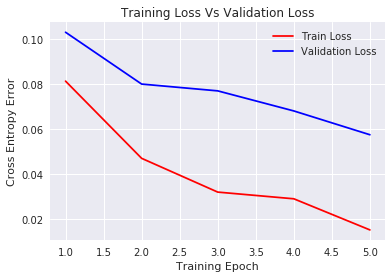

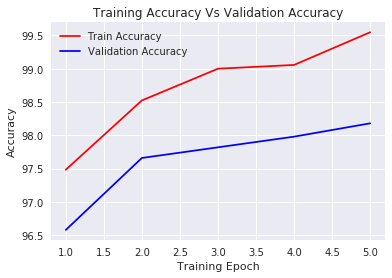

With keep probability: 0.880000
Test accuracy of model :97.939995, Test loss:0.067430


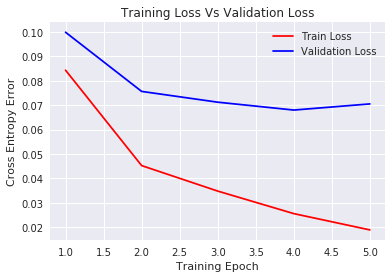

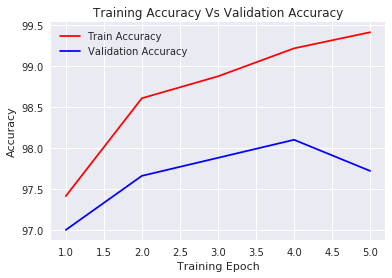

With keep probability: 0.920000
Test accuracy of model :97.899994, Test loss:0.067173


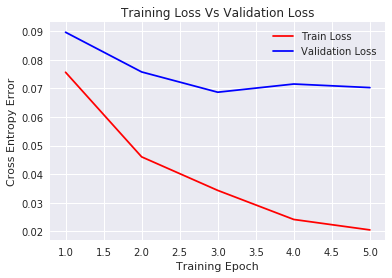

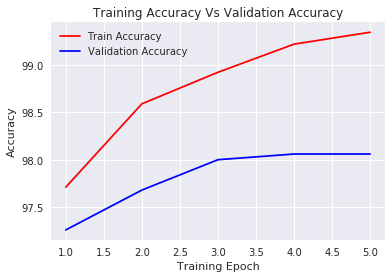

In [10]:
# buid the model a
mlp_b = build_model_b(X)

#keep_prob_val = 0.92
keep_prob_val_list_b = [0.80, 0.84, 0.88, 0.92]
num_epochs = 5

# decalre a list for all the dropout value metrics
metric_list_b = list()

# try with different dropout rate
for keep_prob_val in keep_prob_val_list_b:
    
    print('='*100)
    
    print('With keep probability: %f'%keep_prob_val)
    
    # train and evaluate the model
    ts_loss_mlp_b, ts_acc_mlp_b, train_metric_list, val_metric_list = train_and_evaluate_model(mlp_b , 
                                                                        keep_prob_val, num_epochs)
    # append to list
    metric_list_b.append(( ts_loss_mlp_b, ts_acc_mlp_b,))

    # plot the loss curve
    plot_loss_curve(train_metric_list, val_metric_list)
    # plot the accuracy curve
    plot_accuracy_curve(train_metric_list, val_metric_list)
    
    print('='*100)

## Observation

%%HTML
<ul>
<li> 0.84 is the best keep_prob for which the model showed best performance</li>
</ul>

## c) MLP with 5 Hidden layers, dropout, batch normalization

In [11]:
def build_model_c(X):
    """
    This functions builds the architecture for the MLP.
    """

    # model architecture
    num_input_neurons = 784
    num_hidden_neurons_1 =  489
    num_hidden_neurons_2 = 265
    num_hidden_neurons_3 = 112
    num_hidden_neurons_4 = 40
    num_hidden_neurons_5 = 22
    num_output_neurons = 10
    
    # for relu activation function we need to use He normal initialization of weights as follows
    # If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
    # weights =>  σ=√(2/(fan_in+1) => N(0,σ)
    
    # relu activation specific standard deviations
    l1_stddev = math.sqrt(2 / (num_input_neurons + 1))
    l2_stddev = math.sqrt(2 / (num_hidden_neurons_1 + 1))
    l3_stddev = math.sqrt(2 / (num_hidden_neurons_2 + 1))
    l4_stddev = math.sqrt(2 / (num_hidden_neurons_3 + 1))
    l5_stddev = math.sqrt(2 / (num_hidden_neurons_4 + 1))
    out_stddev = math.sqrt(2 / (num_hidden_neurons_5 + 1))
    

    # ====================================== hidden layer 1 ============================================
    l1_weights = tf.Variable(tf.random_normal(shape=[num_input_neurons, num_hidden_neurons_1], 
                                              mean=0.0, stddev=l1_stddev))
    l1_biases  = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_1], mean=0.0, stddev=l1_stddev))
    
    l1_net_input = tf.matmul(X, l1_weights) + l1_biases
    l1_output = tf.nn.relu(l1_net_input) # activation function
    #===================================================================================================
    
     # ====================================== hidden layer 2 ============================================
    l2_weights = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_1, num_hidden_neurons_2], 
                                              mean=0.0, stddev=l2_stddev))
    l2_biases  = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_2], mean=0.0, stddev=l2_stddev))
    
    l2_net_input = tf.matmul(l1_output, l2_weights) + l2_biases
    
    # apply batch normalization
    # Calculate the mean and variance of x.
    batch_mean_l2, batch_var_l2 = tf.nn.moments(l2_net_input, [0])
    
    alpha_l2 = tf.Variable(tf.ones([num_hidden_neurons_2]))
    beta_l2 = tf.Variable(tf.zeros([num_hidden_neurons_2]))
    
    # do batch normalization on net input
    epsilon = 1e-03
    l2_net_input = tf.nn.batch_normalization(l2_net_input, batch_mean_l2, batch_var_l2, 
                                               beta_l2, alpha_l2, epsilon)
    
    
    
    l2_output = tf.nn.relu(l2_net_input) # activation function
    #===================================================================================================
    
    # ====================================== hidden layer 3 ============================================
    l3_weights = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_2, num_hidden_neurons_3], 
                                              mean=0.0, stddev=l3_stddev))
    l3_biases  = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_3], mean=0.0, stddev=l3_stddev))
    
    l3_net_input = tf.matmul(l2_output, l3_weights) + l3_biases
    
    # apply batch normalization
    # Calculate the mean and variance of x.
    batch_mean_l3, batch_var_l3 = tf.nn.moments(l3_net_input, [0])
    
    alpha_l3 = tf.Variable(tf.ones([num_hidden_neurons_3]))
    beta_l3 = tf.Variable(tf.zeros([num_hidden_neurons_3]))
    
    # do batch normalization on net input
    epsilon = 1e-03
    l3_net_input = tf.nn.batch_normalization(l3_net_input, batch_mean_l3, batch_var_l3, 
                                               beta_l3, alpha_l3, epsilon)
    
    
    
    l3_output = tf.nn.relu(l3_net_input) # activation function
    l3_output = tf.nn.dropout(l3_output, keep_prob=keep_probability)
    #===================================================================================================
    
    # ====================================== hidden layer 4 ============================================
    l4_weights = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_3, num_hidden_neurons_4], 
                                              mean=0.0, stddev=l4_stddev))
    l4_biases  = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_4], mean=0.0, stddev=l4_stddev))
    
    l4_net_input = tf.matmul(l3_output, l4_weights) + l4_biases
    
    # apply batch normalization
    # Calculate the mean and variance of x.
    batch_mean_l4, batch_var_l4 = tf.nn.moments(l4_net_input, [0])
    
    alpha_l4 = tf.Variable(tf.ones([num_hidden_neurons_4]))
    beta_l4 = tf.Variable(tf.zeros([num_hidden_neurons_4]))
    
    # do batch normalization on net input
    epsilon = 1e-03
    l4_net_input = tf.nn.batch_normalization(l4_net_input, batch_mean_l4, batch_var_l4, 
                                               beta_l4, alpha_l4, epsilon)
    
    l4_output = tf.nn.relu(l4_net_input) # activation function
    l4_output = tf.nn.dropout(l4_output, keep_prob=keep_probability)
    #===================================================================================================
    
    
    # ====================================== hidden layer 5 ============================================
    l5_weights = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_4, num_hidden_neurons_5], 
                                              mean=0.0, stddev=l5_stddev))
    l5_biases  = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_5], mean=0.0, stddev=l5_stddev))
    
    l5_net_input = tf.matmul(l4_output, l5_weights) + l5_biases
    
    # apply batch normalization
    # Calculate the mean and variance of x.
    batch_mean_l5, batch_var_l5 = tf.nn.moments(l5_net_input, [0])
    
    alpha_l5 = tf.Variable(tf.ones([num_hidden_neurons_5]))
    beta_l5 = tf.Variable(tf.zeros([num_hidden_neurons_5]))
    
    # do batch normalization on net input
    epsilon = 1e-03
    l5_net_input = tf.nn.batch_normalization(l5_net_input, batch_mean_l5, batch_var_l5, 
                                               beta_l5, alpha_l5, epsilon)
    
    l5_output = tf.nn.relu(l5_net_input) # activation function
    l5_output = tf.nn.dropout(l5_output, keep_prob=keep_probability)
    #===================================================================================================
    
    
    # ================================  output layer ===================================================
    l6_weights = tf.Variable(tf.random_normal(shape=[num_hidden_neurons_5, num_output_neurons], 
                                              mean=0.0, stddev=out_stddev))
    l6_biases  = tf.Variable(tf.random_normal(shape=[num_output_neurons], mean=0.0, stddev=out_stddev))
    
    l6_net_input = tf.matmul(l5_output, l6_weights) + l6_biases
    
    # ==================================================================================================
    
    # return output using the softmax layer
    output = tf.nn.softmax(l6_net_input)
    
    return output

With keep probability: 0.820000
Test accuracy of model :97.809998, Test loss:0.082611


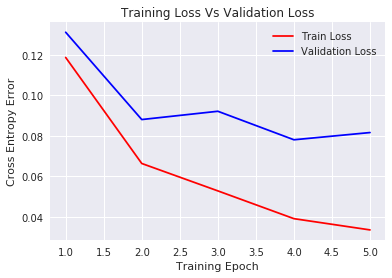

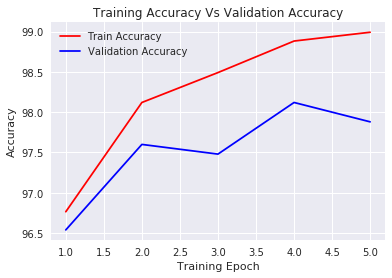

With keep probability: 0.860000
Test accuracy of model :98.029999, Test loss:0.076954


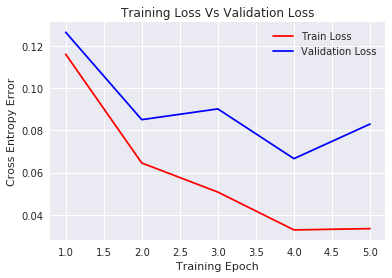

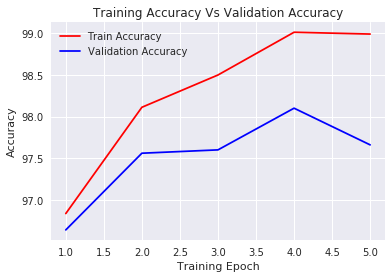

With keep probability: 0.900000
Test accuracy of model :97.860001, Test loss:0.080251


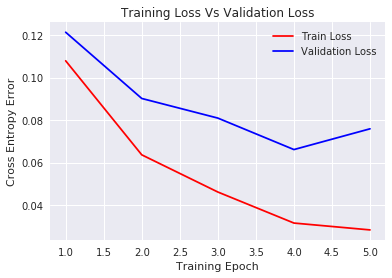

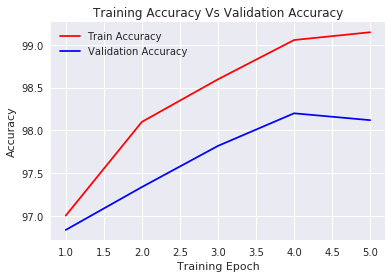

With keep probability: 0.940000
Test accuracy of model :98.009995, Test loss:0.070729


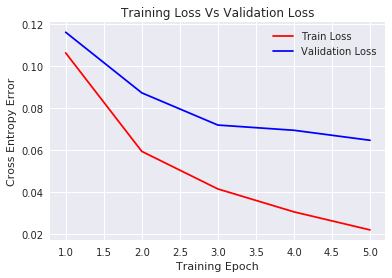

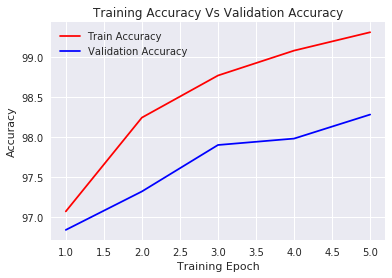

In [12]:
# buid the model a
mlp_c = build_model_c(X)

# train and evaluate the model
#keep_prob_val = 0.92
keep_prob_val_list_c = [0.82, 0.86, 0.90, 0.94]
num_epochs = 5

# decalre a list for all the dropout value metrics
metric_list_c = list()

# try with different dropout rate
for keep_prob_val in keep_prob_val_list_c:
    
    print('='*100)
    
    print('With keep probability: %f'%keep_prob_val)
    
    ts_loss_mlp_c, ts_acc_mlp_c, train_metric_list, val_metric_list = train_and_evaluate_model(mlp_c , 
                                                                                keep_prob_val, num_epochs)
    # append results to list                                                                            
    metric_list_c.append(( ts_loss_mlp_c, ts_acc_mlp_c,))
    
    # plot the loss curve
    plot_loss_curve(train_metric_list, val_metric_list)
    # plot the accuracy curve
    plot_accuracy_curve(train_metric_list, val_metric_list)
    
    print('='*100)

## Observation

%%HTML
<ul>
<li> Model showed best performace on test data set with 0.86 keep_prob value</li>
</ul>

# Procedure Summary

%%HTML
<ol>
<li> Design various MLP networks with different number of layers, neuros , batch normalization, dropout rate</li>
<li> Train and evaluate all the models to see its performance </li>
<li> Select the best model based on the loss value as well as accuracy on unseen data </li>
</ol>

# Results Summary

In [13]:
from prettytable import PrettyTable

In [14]:
ptable = PrettyTable()
ptable.title = 'Comparison of MLP Models'
ptable.field_names = ['Model', 'Architecure', 'Keep_Prob', 'Loss', 'Accuracy']

In [15]:
# append result of model a with no dropout
ptable.add_row(['MLP-a', '2-HL', 1.0, ts_loss_mlp_a, ts_acc_mlp_a, ])

# append results of model b
for index, keep_prob_val in enumerate(keep_prob_val_list_b):
    ts_loss_mlp_b = metric_list_c[index][0]
    ts_acc_mlp_b = metric_list_c[index][1]
    ptable.add_row(['MLP-b', '3-HL, 2-Dropout, 2-BN', keep_prob_val, ts_loss_mlp_b, ts_acc_mlp_b,])

# append results of model c
for index, keep_prob_val in enumerate(keep_prob_val_list_c):
    ts_loss_mlp_c = metric_list_c[index][0]
    ts_acc_mlp_c = metric_list_c[index][1]
    ptable.add_row(['MLP-c', '5-HL, 3-Dropout, 4-BN', keep_prob_val,ts_loss_mlp_c, ts_acc_mlp_c,])

In [16]:
print(ptable)

+---------------------------------------------------------------------+
|                       Comparison of MLP Models                      |
+-------+-----------------------+-----------+-------------+-----------+
| Model |      Architecure      | Keep_Prob |     Loss    |  Accuracy |
+-------+-----------------------+-----------+-------------+-----------+
| MLP-a |          2-HL         |    1.0    | 0.074358895 |    98.0   |
| MLP-b | 3-HL, 2-Dropout, 2-BN |    0.8    |  0.08261111 |   97.81   |
| MLP-b | 3-HL, 2-Dropout, 2-BN |    0.84   |  0.07695403 |   98.03   |
| MLP-b | 3-HL, 2-Dropout, 2-BN |    0.88   |  0.08025092 |   97.86   |
| MLP-b | 3-HL, 2-Dropout, 2-BN |    0.92   | 0.070729315 | 98.009995 |
| MLP-c | 5-HL, 3-Dropout, 4-BN |    0.82   |  0.08261111 |   97.81   |
| MLP-c | 5-HL, 3-Dropout, 4-BN |    0.86   |  0.07695403 |   98.03   |
| MLP-c | 5-HL, 3-Dropout, 4-BN |    0.9    |  0.08025092 |   97.86   |
| MLP-c | 5-HL, 3-Dropout, 4-BN |    0.94   | 0.070729315 | 98.0

# Conclusion

%%HTML
<ul>
<li> In this assignment, various architecture of MLPs have been tried and evaluated on MNIST data set</li>
<li> All models showed test accuracy above 97%</li>
<li> Batch Normalization version showed less deviation between train, validation loss </li>
<li> The network with more layeres and complicated architectures (model_b, moidel_c) showed a tendacy 
     to overfit when compared with simple model_a</li>
<li> For MNIST dataset, simple model (model_a) can be used as it showed relatively small 
     loss and good accuracy</li>
</ul>